### Описание датасета

A data frame with 53940 rows and 10 variables:

price - price in US dollars ($326–$18,823)  
carat - weight of the diamond (0.2–5.01)  
cut - quality of the cut (Fair, Good, Very Good, Premium, Ideal)  
color - diamond colour, from D (best) to J (worst)  
clarity - a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))  
x - length in mm (0–10.74)  
y - width in mm (0–58.9)  
z - depth in mm (0–31.8)  
depth - total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43–79)  
table - width of top of diamond relative to widest point (43–95)

### Загрузка данных

In [50]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm

In [3]:
item = 'diamonds' # Выбрать из поля Item для вашего датасета
package = 'ggplot2' # Выбрать из поля Package для вашего датасета

df = sm.datasets.get_rdataset(item, package , cache=True).data
df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [4]:
cut_dict = {
    'Fair' : 0,
    'Good' : 1, 
    'Very Good' : 2, 
    'Premium' : 3,
    'Ideal' : 4
}

df['cut_value'] = df['cut'].map(cut_dict)

### 1. Очистить от выбросов и пропусков

In [5]:
df.isna().sum()

carat        0
cut          0
color        0
clarity      0
depth        0
table        0
price        0
x            0
y            0
z            0
cut_value    0
dtype: int64

Пропусков нет

In [6]:
def drop_outliers(df, variable):
    q1 = df[variable].quantile(0.25)
    q3 = df[variable].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5*iqr
    upper_bound = q3 + 1.5*iqr
    print(variable, lower_bound, upper_bound)
    return df[(df[variable]>=lower_bound)&(df[variable]<=upper_bound)]

In [7]:
df = drop_outliers(df, "price")
df = drop_outliers(df, "carat")

price -5611.375 11885.625
carat -0.5650000000000001 1.955


In [8]:
df

,carat,cut,color,clarity,depth,table,price,x,y,z,cut_value
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,4
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,3
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,1
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,3
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,1
...,...,...,...,...,...,...,...,...,...,...,...
53935,0.72,Ideal,D,SI1,60.8,57.0,2757,5.75,5.76,3.50,4
53936,0.72,Good,D,SI1,63.1,55.0,2757,5.69,5.75,3.61,1
53937,0.70,Very Good,D,SI1,62.8,60.0,2757,5.66,5.68,3.56,2
53938,0.86,Premium,H,SI2,61.0,58.0,2757,6.15,6.12,3.74,3


Очищены выбросы по цене и весу. По этим переменным будем строить дальнейшие гипотезы. Удалены записи с ценой более 11885.625 и весом более 1.955. Нижняя граница выбросов по обеим переменным меньше нуля - таких значений в наборе данных нет.

### 2. Выберите две количественные переменные и найдите для них 95% доверительные интервалы средних значений.

In [9]:
def confidence_interval(data):
    alpha = 0.95

    mean = data.mean()
    var = data.var()
    n = data.count()

    ci = stats.norm.interval(confidence = alpha, loc = mean, scale = np.sqrt(var/n))
    return ci


In [10]:
df_fair_carat = df.loc[df['cut_value']==0, 'carat']
df_ideal_carat = df.loc[df['cut_value']==4, 'carat']

ci_fair = confidence_interval(df_fair_carat)
print(f'95% доверительный интервал для среднего веса некачественного алмаза от {ci_fair[0].round(4)} до {ci_fair[1].round(4)} карат')

ci_ideal = confidence_interval(df_ideal_carat)
print(f'95% доверительный интервал для среднего веса идеального алмаза от {ci_ideal[0].round(4)} до {ci_ideal[1].round(4)} карат')

95% доверительный интервал для среднего веса некачественного алмаза от 0.8928 до 0.9258 карат
95% доверительный интервал для среднего веса идеального алмаза от 0.6354 до 0.6449 карат


In [11]:
df_fair_price = df.loc[df['cut_value']==0, 'price']
df_ideal_price = df.loc[df['cut_value']==4, 'price']

ci_fair = confidence_interval(df_fair_price)
print(f'95% доверительный интервал для средней цены некачественного алмаза от {ci_fair[0].round(4)} до {ci_fair[1].round(4)}')

ci_ideal = confidence_interval(df_ideal_price)
print(f'95% доверительный интервал для средней цены идеального алмаза от {ci_ideal[0].round(4)} до {ci_ideal[1].round(4)}')


95% доверительный интервал для средней цены некачественного алмаза от 3308.6601 до 3527.0595
95% доверительный интервал для средней цены идеального алмаза от 2759.2737 до 2832.8451


### 3. Оценить распределение этих переменных на нормальность

#### 3.1. с помощью формальных тестов

In [39]:
stats.shapiro(df_fair_carat)

ShapiroResult(statistic=np.float64(0.9573175381143282), pvalue=np.float64(4.626372740039115e-20))

Значение pvalue очень низкое (ниже 0.05), следовательно вес некачественных алмазов не имеет нормального распределения.

In [40]:
stats.shapiro(df_ideal_carat)

c:\Python312\Lib\site-packages\scipy\stats\_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20360.
  res = hypotest_fun_out(*samples, **kwds)


ShapiroResult(statistic=np.float64(0.8738415132541244), pvalue=np.float64(2.2905722430139315e-82))

Значение pvalue также очень низкое. Но тесту не нравиться слишком большое количество наблюдений. Попробуем его сократить.

In [41]:
stats.shapiro(df_ideal_carat.sample(1000))

ShapiroResult(statistic=np.float64(0.8744214077782233), pvalue=np.float64(1.2838245063678612e-27))

Ничего не изменилось. Данные по весу не имеют нормального распределения.

In [42]:
stats.shapiro(df.sample(1000)['carat'])

ShapiroResult(statistic=np.float64(0.9265625647091488), pvalue=np.float64(1.0668956880920195e-21))

И для всего датасета тоже.

In [43]:
(
    stats.shapiro(df_fair_price), 
    stats.shapiro(df_ideal_price.sample(1000)), 
    stats.shapiro(df['price'].sample(1000))
)

(ShapiroResult(statistic=np.float64(0.9150321702202072), pvalue=np.float64(1.2827358606253853e-27)),
 ShapiroResult(statistic=np.float64(0.8107103551197901), pvalue=np.float64(1.1687396478843159e-32)),
 ShapiroResult(statistic=np.float64(0.8601313091396809), pvalue=np.float64(6.725190283026305e-29)))

Цена тоже ни в каком варианте не имеет нормального распределения.

#### 3.2. с помощью альтернативных методов.

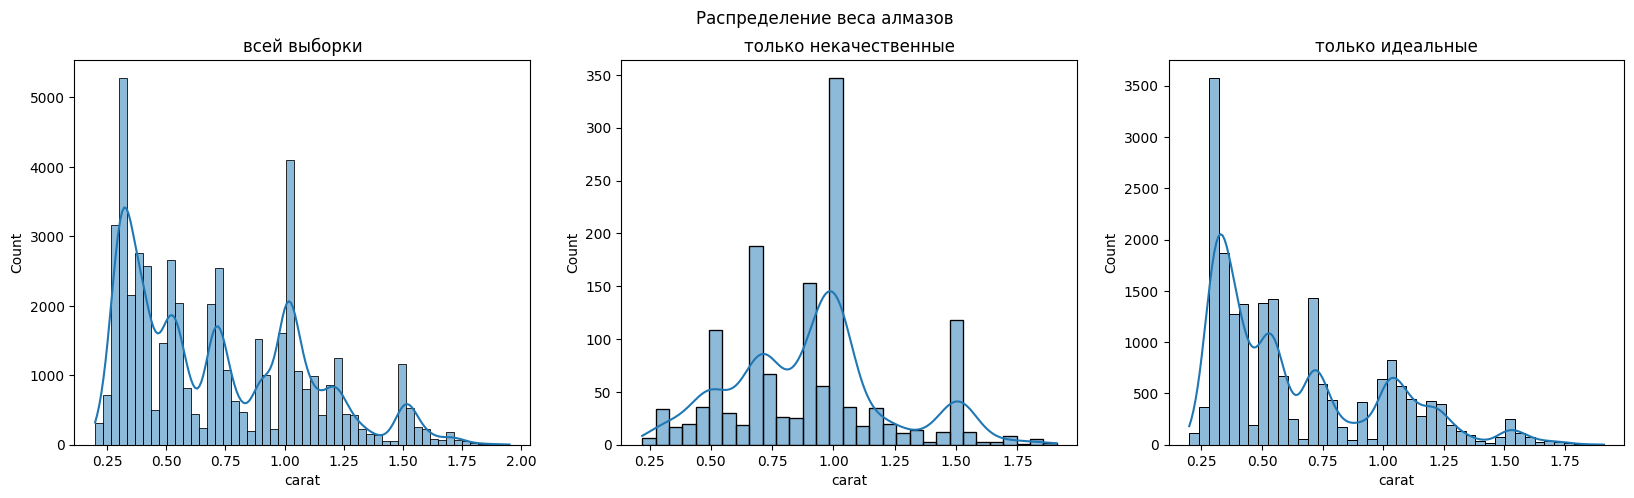

In [37]:
fig, ax  = plt.subplots(1,3, figsize = (20,5))
plt.suptitle('Распределение веса алмазов')
sns.histplot(df['carat'], kde = True, ax = ax[0])
ax[0].set_title("всей выборки")
sns.histplot(df_fair_carat, kde = True, ax = ax[1])
ax[1].set_title("только некачественные")
sns.histplot(df_ideal_carat, kde = True, ax = ax[2])
ax[2].set_title("только идеальные")
plt.show()


На всех графиках видим, что распределение не нормальное.

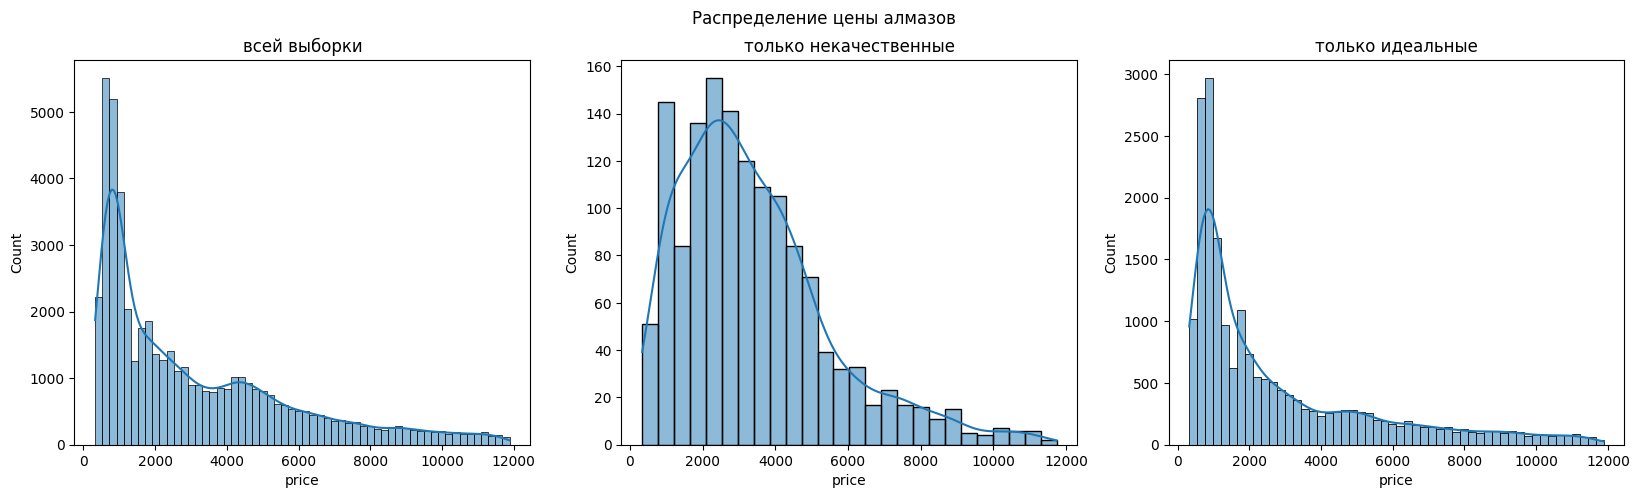

In [36]:
fig, ax  = plt.subplots(1,3, figsize = (20,5))
plt.suptitle('Распределение цены алмазов')
sns.histplot(df['price'], kde = True, ax = ax[0])
ax[0].set_title("всей выборки")
sns.histplot(df_fair_price, kde = True, ax = ax[1])
ax[1].set_title("только некачественные")
sns.histplot(df_ideal_price, kde = True, ax = ax[2])
ax[2].set_title("только идеальные")
plt.show()

И с ценой тоже.

### 4. Возьмите две группы наблюдений и протестируйте гипотезу о равенстве математических ожиданий (двухвыборочный т-тест или тест Манна-Уитни в зависимости от результата теста на нормальность).

Проверим гипотезу о том, что средний вес некачественных и идеальных алмазов равны. Поскольку данные распеделены не нормально, используем тест Манна-Уитни.

In [47]:
stats.mannwhitneyu(df_fair_carat, df_ideal_carat, alternative = 'two-sided')

MannwhitneyuResult(statistic=np.float64(20887322.0), pvalue=np.float64(2.3489531321416e-164))

Поскольку pvalue значительно меньше 5%, нулевая гипотеза отвергается. Средний вес идеальных и некачественных алмазов не равны.

### 5. Постройте точечную диаграмму (scatterplot) и оцените корреляцию между переменными. 

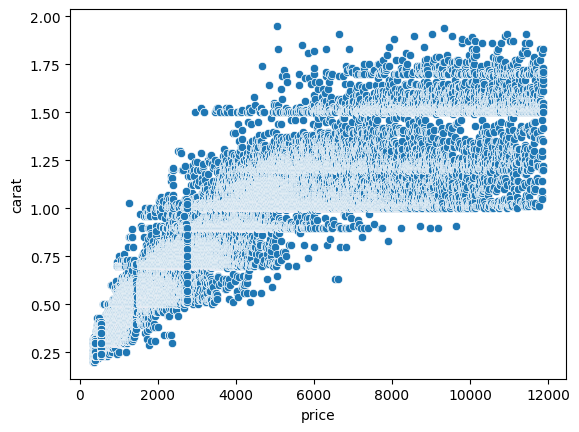

In [48]:
sns.scatterplot(data = df, x = 'price', y = 'carat')
plt.show()

In [49]:
stats.pearsonr(df['price'], df['carat'])

PearsonRResult(statistic=np.float64(0.9187713335980271), pvalue=np.float64(0.0))

Между ценой и весом есть сильная линейная зависимость.

### 6. Оцените модель линейной регрессии. Сделайте на ее основе прогноз и вывод по результатам.

In [51]:
X = np.array(df['carat'])
Y = np.array(df['price'])
X = sm.add_constant(X)
model = sm.OLS(Y, X)
results = model.fit()
print(results.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                 2.714e+05
Date:                Thu, 14 Nov 2024   Prob (F-statistic):               0.00
Time:                        11:23:15   Log-Likelihood:            -4.2098e+05
No. Observations:               50119   AIC:                         8.420e+05
Df Residuals:                   50117   BIC:                         8.420e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1725.7279     10.473   -164.780      0.0

 - R-squared: 0.844 означает, что 84.4% изменчивости цены объясняется весом в каратах.
 - p-value для x1: Очень малое значение (0.000) указывает на значимость переменной carat.
 - Коэффициент x1: Значение 6773 означает, что увеличение веса алмаза на 1 карат связано с увеличением цены на 1000 единиц.